Trying to figure out an efficient sampling method.

In [81]:
from SALib.sample import saltelli, morris, latin
from SALib.analyze import sobol, rbd_fast, hdmr
from SALib.analyze import morris as morris_analyze
from SALib.test_functions import Ishigami, Sobol_G
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd

In [72]:
# Define the model inputs
problem = {
    'num_vars': 8,
    'names': [f'x{i}' for i in range(8)],
    'bounds': [[0, 1]*8],
}
sensitivity_indices = {}
n_list = 2**np.arange(6, 12, 1)
names = ["sobol", "morris", "rbd", ]
samplers = [saltelli, morris, latin,]
analyzers = [sobol, morris_analyze, rbd_fast]
total_samples = {}
for name, sampler, analyzer in tqdm(zip(names, samplers, analyzers), total=len(names), position=0):
    results = []
    counts = []
    for n_samples in tqdm(n_list, position=1, leave=False):
        # Generate samples
        param_values = sampler.sample(problem, N=n_samples)

        # Run model (example)
        Y = Sobol_G.evaluate(param_values)

        # Perform analysis
        try:
            Si = analyzer.analyze(problem, Y)
        except TypeError:
            Si = analyzer.analyze(problem, param_values, Y)

        results.append(Si.to_df())
        counts.append(param_values.shape[0])
    total_samples[name] = counts
    sensitivity_indices[name] = results

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [74]:
def samples_plot(sensitivities: list, this_counts, accessor, ax):
    total_indices_dfs = []
    for n_samples, dfs in zip(
        this_counts, sensitivities
    ):
        df = accessor(dfs)
        df["Samples"] = n_samples
        total_indices_dfs.append(df)
    total_indices = pd.concat(total_indices_dfs)
    for i in range(8):
        ax.plot(total_indices["Samples"], total_indices[f"x{i}"], label=f"x{i}")
    ax.legend()
    ax.set_xlabel("Samples")

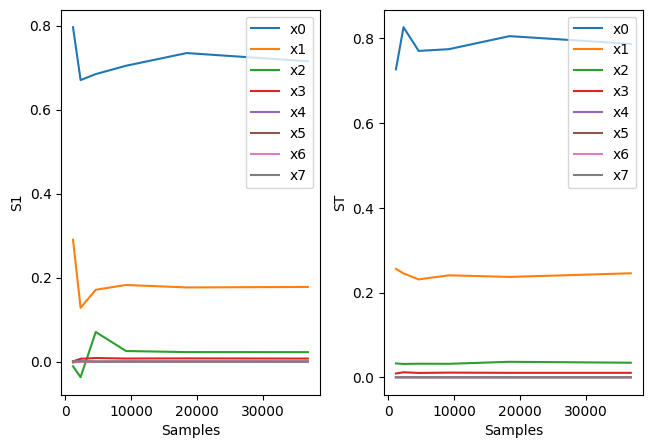

In [76]:
fig, axes = plt.subplots(1,2, figsize=(7.5, 5))
fig.subplots_adjust(wspace=0.25)

axes[0].set_ylabel("S1")
sobol_accessor = lambda r: r[1][["S1"]].T
samples_plot(
    sensitivity_indices["sobol"], 
    total_samples["sobol"],
    sobol_accessor, 
    axes[0]
)

axes[1].set_ylabel("ST")
sobol_accessor = lambda r: r[0][["ST"]].T
samples_plot(
    sensitivity_indices["sobol"], 
    total_samples["sobol"],
    sobol_accessor, 
    axes[1]
)

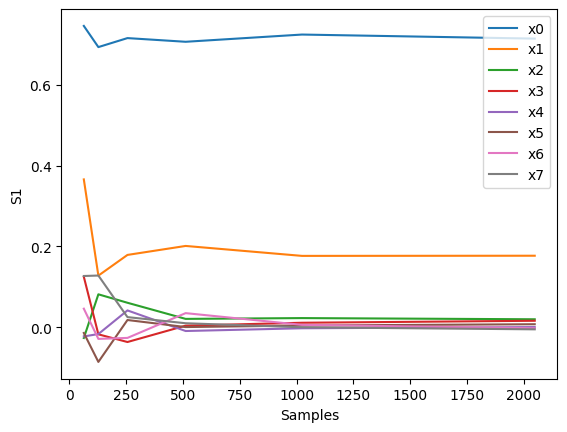

In [80]:
fig, ax = plt.subplots(1)
fig.subplots_adjust(wspace=0.25)

ax.set_ylabel("S1")
rbd_accessor = lambda r: r[["S1"]].T
samples_plot(
    sensitivity_indices["rbd"], 
    total_samples["rbd"],
    rbd_accessor, 
    ax
)

RBD can achieve stable results with 1/20th the samples of SOBOL (~1000 vs 20000).